### Libraries

In [5]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


# python imports
import re
import json
import os
from collections import Counter
import datetime as dt
from dateutil.parser import parse


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook
import geopandas as gpd


# twitter
# pip install twarc
from twarc import Twarc
import carmen
import pycountry as pc

resolver = carmen.get_resolver()
resolver.load_locations()


# Saving models
import pickle

import config

#### Function to check if the string is datetime

In [6]:
def isDate(string, fuzzy=False):
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

#### Function to extract the location from the tweets using carmen

In [7]:
def getLocation(t):
    fields = ['entities', 'user', 'place', 'coordinates']
    for field in fields:
        if(pd.isna(t[field]) or t[field].isnumeric() or (t[field] == 'True' or t[field] == 'False')):
            t[field] = dict()
        else:
            t[field] = eval(t[field])
    
    location = resolver.resolve_tweet(t)
    return location

### Reading the tweets and updating their geodata

In [ ]:
main_dir = './'
full_dir = main_dir + 'data_full/'
id_dir = main_dir + 'data_ids/'

df_list = []

for file in sorted(os.listdir(full_dir)[:-2]):
    print('reading... ' + file)
    
    df_full = pd.read_csv(full_dir + file).drop_duplicates()
    df_full = df_full.dropna(subset = ['id'])
    
    df_full = df_full[df_full.created_at.apply(isDate)]
    df_full.to_csv(full_dir + file, index = None)
    
    df_full['locations'] = df_full.apply(getLocation, axis = 1)
    df_full[['id', 'locations']].to_csv(full_dir + 'locations/' + file[:-9] + '_loc.csv', index = None)
    df_list.append(df_full)
    
    print(file + ' ..done')
    print()
    
    
    

reading... 05-01-2020_full.csv
05-01-2020_full.csv ..done

reading... 05-02-2020_full.csv
05-02-2020_full.csv ..done

reading... 05-03-2020_full.csv
05-03-2020_full.csv ..done

reading... 05-04-2020_full.csv
05-04-2020_full.csv ..done

reading... 05-05-2020_full.csv
05-05-2020_full.csv ..done

reading... 05-06-2020_full.csv
05-06-2020_full.csv ..done

reading... 05-07-2020_full.csv
05-07-2020_full.csv ..done

reading... 05-08-2020_full.csv
05-08-2020_full.csv ..done

reading... 05-09-2020_full.csv
05-09-2020_full.csv ..done

reading... 05-10-2020_full.csv
05-10-2020_full.csv ..done

reading... 05-12-2020_full.csv
05-12-2020_full.csv ..done

reading... 05-13-2020_full.csv
05-13-2020_full.csv ..done

reading... 05-14-2020_full.csv


### Merging all the data

In [17]:
df = pd.concat(df_list)
df.reset_index().drop('index', axis = 1)
df.tail()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,locations
326953,Mon May 18 23:58:53 +0000 2020,1262533146643439616,1262533146643439616,A nice interview on the #LunaStationQuaterly w...,False,"[0, 227]","{'hashtags': [{'text': 'LunaStationQuaterly', ...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,NaN,NaN,False,0,1,False,False,False,en,"(False, Location(country='Canada', state='Onta..."
326954,Mon May 18 23:58:52 +0000 2020,1262533142025568258,1262533142025568258,“the Treasury Department had spent very little...,False,"[0, 185]","{'hashtags': [{'text': 'Coronavirus', 'indices...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,NaN,NaN,False,96,179,False,False,False,en,None
326955,Mon May 18 23:59:28 +0000 2020,1262533292689108993,1262533292689108993,#Cuomo + #Covid19 = #CuomoVirus \n\n S...,False,"[0, 161]","{'hashtags': [{'text': 'Cuomo', 'indices': [0,...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,NaN,NaN,False,0,1,False,False,NaN,en,None
326956,Mon May 18 23:59:27 +0000 2020,1262533288683544577,1262533288683544577,#COVID19 fallout provides window for #tortrefo...,False,"[0, 286]","{'hashtags': [{'text': 'COVID19', 'indices': [...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,NaN,...,NaN,NaN,False,0,0,False,False,False,en,"(False, Location(country='United States', stat..."
326957,Mon May 18 23:59:29 +0000 2020,1262533298871468032,1262533298871468032,"Smart Steps Mobile is a free download, but now...",False,"[0, 238]","{'hashtags': [{'text': 'distancelearning', 'in...","<a href=""https://commun.it"" rel=""nofollow"">Com...",NaN,NaN,...,NaN,NaN,False,0,0,False,False,False,en,None


### Temporal frequency of tweets

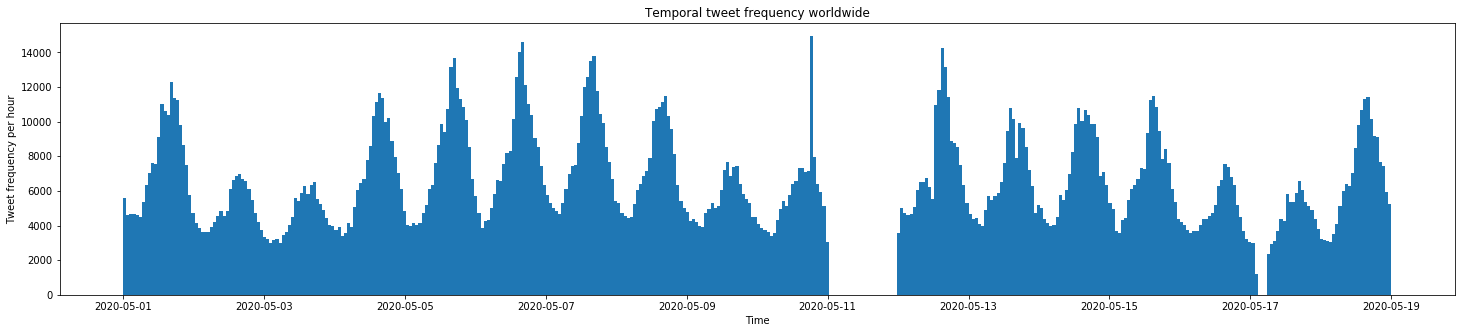

In [18]:
df = df[df.created_at.apply(isDate)]

fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency worldwide', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(pd.to_datetime(df.created_at), bins = 24*len(df_list))
plt.show()

### Spatial frequency of tweets

In [ ]:
locs = df.locations.apply(getCountry).dropna()
country_df = pd.DataFrame.from_dict(Counter(locs), columns = ['count'], orient = 'index').reset_index()
country_df.columns = ['country', 'count']
code_freq_df = pd.merge(country_df, codes_df, on = 'country', how = 'left')
code_freq.to_csv('./data_full/locations/country_frequency.csv', index = None)
code_freq_df.head()

In [ ]:
country_freq_df = pd.merge(world, code_freq_df, on='code')

fig, ax = plt.subplots(1, figsize=(30,15))
fig.suptitle('Countrywise tweet frequency for a period of ' + str(len(df_list)) + ' days', fontsize = 20)
ax.axis('off')
country_freq_df.plot(ax=ax, column='count', legend=True, cmap = 'Paired')

### Picking out the tweet texts

In [ ]:
text_en = df['full_text']
text_en.tail()
print(text_en.iloc[0])

### Removing URLs from tweets

In [ ]:
text_en_lr = text_en.apply(lambda x: re.sub(r"https\S+", "", str(x)))
text_en_lr.tail()
print(text_en_lr.iloc[0])

### Converting all tweets to lowercase

In [ ]:
text_en_lr_lc = text_en_lr.apply(lambda x: x.lower())
text_en_lr_lc.head()
print(text_en_lr_lc.iloc[0])

### Removing punctuations

In [ ]:
text_en_lr_lc_pr = text_en_lr_lc.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
text_en_lr_lc_pr.head()
print(text_en_lr_lc_pr.iloc[0])

### Removing stopwords

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19'])

text_en_lr_lc_pr_sr = text_en_lr_lc_pr.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
text_en_lr_lc_pr_sr.head()
print(text_en_lr_lc_pr_sr.iloc[0])

### Concatenating all the tweets into a list of words

In [ ]:
word_list = [word for line in text_en_lr_lc_pr_sr for word in line.split()]
word_list[:5]

### Calculating the Term Frequency

In [ ]:
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)
plt.savefig('wordcount_bar.png')

In [ ]:
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(word_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('wordcloud.png')



## Sentiment Analysis

### Getting the polarity scores for each tweet

In [ ]:
def getCountry(loc):
    if(loc):
        return loc[1].country
    return None

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = text_en_lr.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores)).reset_index().drop('index', axis = 1)

sent_scores_df['country'] = df['locations'].apply(getCountry).reset_index().drop('index', axis = 1)

sent_scores_df['val'] = sent_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sent_scores_df.head()

### Plotting the sentiment score counts

In [ ]:
sent_counts = pd.DataFrame.from_dict(Counter(sent_scores_df['val']), orient = 'index').reset_index()
sent_counts.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_counts)
plt.savefig('sentiment.png')

### Temporal plot of the sentiments

In [ ]:
sentiments_time_df = pd.DataFrame()
sentiments_time_df['time'] = df['created_at']
sentiments_time_df['polarity'] = sent_scores_df['compound']
sentiments_time_df.index = pd.to_datetime(sentiments_time_df['time'])


ot = sentiments_time_df.sample(frac=.001)
ot['time'] = pd.to_datetime(ot['time'])
ot.index = pd.to_datetime(ot['time'])
ot.sort_index(inplace=True)
ot['expanding'] = ot['polarity'].expanding().mean()
ot['rolling'] = ot['polarity'].rolling('1h').mean()

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.scatter(ot['time'],ot['polarity'], label='Tweet Sentiment', s = 10, color = 'y')
ax.plot(ot['time'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
ax.plot(ot['time'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
ax.set_xlim([dt.date(2020,5,1),dt.date(2020,5,9)])
ax.set(title='Tweet Sentiments over Time', xlabel='Date', ylabel='Sentiment polarity')
ax.legend(loc='best')
fig.tight_layout()
plt.savefig('temporal_sentiments.png')


### Sentiment scores distribution

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set(title='Tweet Sentiments distribution', xlabel='polarity', ylabel='frequency')
sns.distplot(sentiments_time_df['polarity'], bins=30, ax=ax)
# plt.show()
plt.savefig('sentiment_distribution.png')

### Sentiment scores countrywise 

In [ ]:
sent_scores_df.loc[sent_scores_df.country == 'Swaziland', 'country'] = 'Eswatini'
sent_scores_df.loc[sent_scores_df.country == 'South Korea', 'country'] = 'Korea, Republic of'
sent_scores_df.loc[sent_scores_df.country == 'North Korea', 'country'] = "Korea, Democratic People's Republic of"
sent_scores_df.loc[sent_scores_df.country == 'Netherlands Antilles', 'country'] = "Netherlands"
sent_scores_df.loc[sent_scores_df.country == 'Ivory Coast', 'country'] = "Côte d'Ivoire"
sent_scores_df.loc[sent_scores_df.country == 'Macau-China', 'country'] = 'Macao'
sent_scores_df.loc[sent_scores_df.country == 'Democratic Republic of Congo', 'country'] = 'Congo, The Democratic Republic of the'
sent_scores_df.loc[sent_scores_df.country == 'Cape Verde', 'country'] = 'Cabo Verde'
sent_scores_df.loc[sent_scores_df.country == 'St. Lucia', 'country'] = 'Saint Lucia'
sent_scores_df.loc[sent_scores_df.country == 'Palestinian Territories', 'country'] = 'Palestine, State of'

country_codes = [(country, pc.countries.search_fuzzy(country)[0].alpha_3) for country in sent_scores_df.country.drop_duplicates().dropna()]

In [ ]:
codes_df = pd.DataFrame(country_codes, columns = ['country', 'code'])
codes_df.to_csv('country_codes.csv', index = None)

codes_df.head()

In [ ]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

world = world[['name', 'iso_a3', 'geometry']]
world.columns = ['country', 'code', 'geometry']
world.head()

In [ ]:
sent_country_df = sent_scores_df[['compound', 'country']]
sent_means_df = sent_country_df.groupby('country').mean().reset_index()

mean_country_df = pd.merge(sent_means_df, codes_df, on = 'country', how = 'left')
mean_loc_df = pd.merge(world, mean_country_df, on = 'code', how = 'inner')
mean_loc_df = mean_loc_df[['compound', 'code', 'geometry']]
mean_loc_df.tail()



In [ ]:
fig, ax = plt.subplots(1, figsize=(30,15))
ax.axis('off')
fig.suptitle('Mean sentiment scores distribution worldwide for a period of ' + str(len(df_list)) + ' days', fontsize = 20)
mean_loc_df.plot(ax=ax, column='compound', legend=True, cmap = 'coolwarm')

### Word cloud of polar words

In [ ]:
polar_tweets_df = pd.DataFrame()
polar_tweets_df['tweet'] = text_en_lr_lc_pr_sr
polar_tweets_df['polarity'] = sent_scores_df['val']

positive = polar_tweets_df[polar_tweets_df['polarity'] == 'positive']['tweet']
negative = polar_tweets_df[polar_tweets_df['polarity'] == 'negative']['tweet']
neutral = polar_tweets_df[polar_tweets_df['polarity'] == 'neutral']['tweet']

positive_list = [word for line in positive for word in line.split()]
negative_list = [word for line in negative for word in line.split()]
neutral_list = [word for line in neutral for word in line.split()]

positive_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(positive_list))

negative_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(negative_list))

neutral_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral_list))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(positive_cloud)
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')
# axs[0, 0].tight_layout(pad = 1)

axs[0, 1].imshow(negative_cloud)
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')
# axs[0, 1].tight_layout(pad = 1)

axs[1, 0].imshow(neutral_cloud)
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')
# axs[1, 0].tight_layout(pad = 1)

axs[1, 1].imshow(wordcloud)
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
# axs[1, 0].tight_layout(pad = 1)
plt.savefig('joint_cloud.png')



In [ ]:
sorted(os.listdir(full_dir))[:-2]

In [13]:
len(df_list)

17

In [14]:
df_list[-1].shape

(156325, 26)

In [16]:
len(pd.read_csv(full_dir + '05-18-2020_full.csv'))

156325